# Bank Marketing Campaign Analysis & Prediction

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

import shap

from sklearn.metrics import roc_curve, roc_auc_score, auc

import pickle

In [2]:
df_desc = pd.read_csv("DatasetDesc.csv", sep=';') #https://archive.ics.uci.edu/dataset/222/bank+marketing
pd.set_option('display.max_colwidth', None)
df_desc

,Variable Name,Role,Type,Demographic,Description
0,age,Feature,Integer,Age,NaN
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,Feature,Binary,NaN,has credit in default?
5,balance,Feature,Integer,NaN,average yearly balance
6,housing,Feature,Binary,NaN,has housing loan?
7,loan,Feature,Binary,NaN,has personal loan?
8,contact,Feature,Categorical,NaN,"contact communication type (categorical: 'cellular','telephone')"
9,day_of_week,Feature,Date,NaN,last contact day of the week


In [3]:
df = pd.read_csv("dane/bank/bank-full.csv", sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data overview

In [4]:
data = df.copy()
print("Shape of the dataset: ")
data.shape

Shape of the dataset: 


(45211, 17)

In [5]:
print("Null values per column: ")
data.isnull().sum()

Null values per column: 


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
columns = data.select_dtypes(include='object').columns.tolist()
for col in columns:
    print(f"\n{col} – unique values:")
    print((data[col].value_counts()))


job – unique values:
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

marital – unique values:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

education – unique values:
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

default – unique values:
default
no     44396
yes      815
Name: count, dtype: int64

housing – unique values:
housing
yes    25130
no     20081
Name: count, dtype: int64

loan – unique values:
loan
no     37967
yes     7244
Name: count, dtype: int64

contact – unique values:
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

month – unique values:
month
may    13766
jul     6895
aug  

### Vizualization analysis

Dashboard for anaysis:

https://public.tableau.com/views/BankMarketing_17492977902570/BankMarketingCampaignAnalysis?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

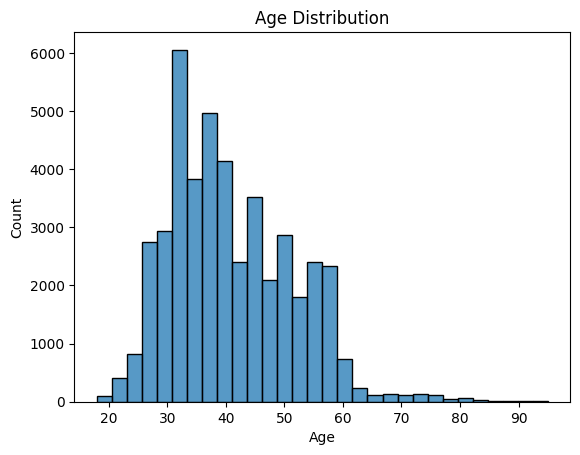

In [7]:
sns.histplot(data['age'], bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The age distribution is right-skewed, with the majority of clients aged between 30 and 40. There is a sharp decline in representation beyond age 60. This indicates that the bank's marketing campaign mostly targets a working-age population.

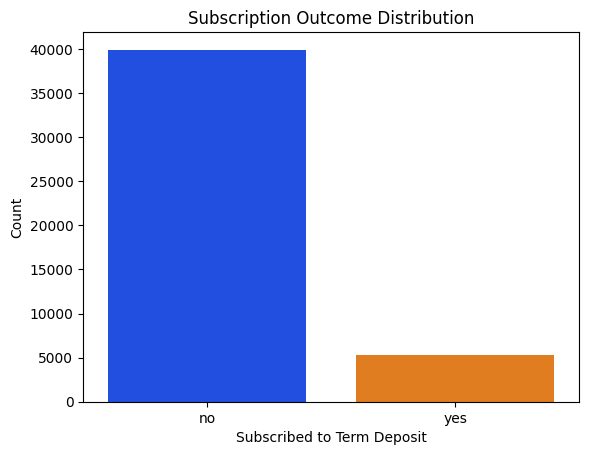

In [8]:
sns.countplot(data=data, x='y', hue='y', palette='bright')
plt.title('Subscription Outcome Distribution')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.show()

The target variable y is highly imbalanced: around 85-90% of clients did not subscribe to a term deposit, while only around 10-15% did.

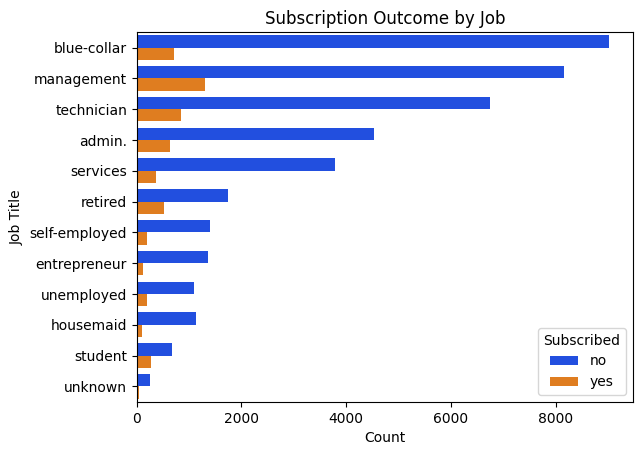

In [9]:
job_order = data['job'].value_counts().index
sns.countplot(data=data, y='job', order=job_order, hue='y', palette='bright')
plt.title('Subscription Outcome by Job')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.legend(title='Subscribed')
plt.show()


Most clients belong to the "blue-collar", "management", and "technician" job categories.

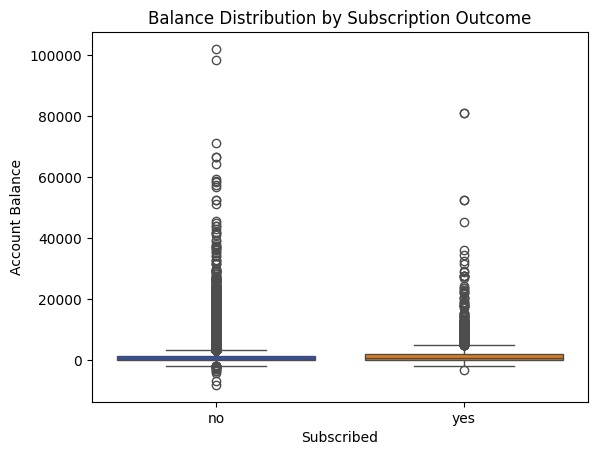

In [10]:
sns.boxplot(data=data, x='y', y='balance', hue='y', palette='bright')
plt.title('Balance Distribution by Subscription Outcome')
plt.xlabel('Subscribed')
plt.ylabel('Account Balance')
plt.show()

Although the median account balance is slightly higher for clients who subscribed (yes), the variable is heavily skewed by outliers in both groups. The overlap in boxplots suggests that balance alone is not a strong predictor.

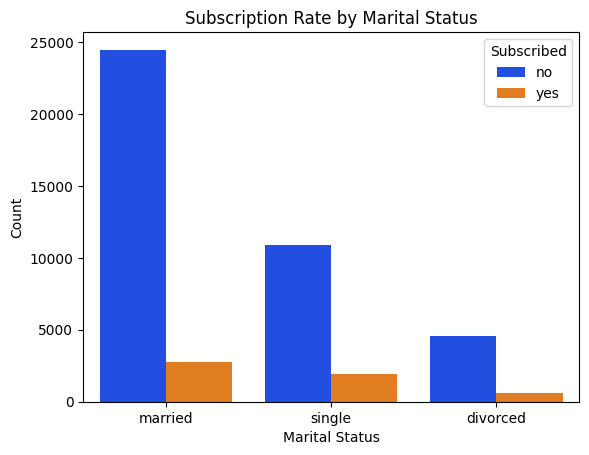

In [11]:
sns.countplot(data=data, x='marital', hue='y', palette='bright')
plt.title('Subscription Rate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Subscribed')
plt.show()

Married individuals represent the largest portion of the dataset but have the lowest conversion rate. Interestingly, single clients are relatively more likely to subscribe, which may hint at lifestyle-based financial behavior differences.

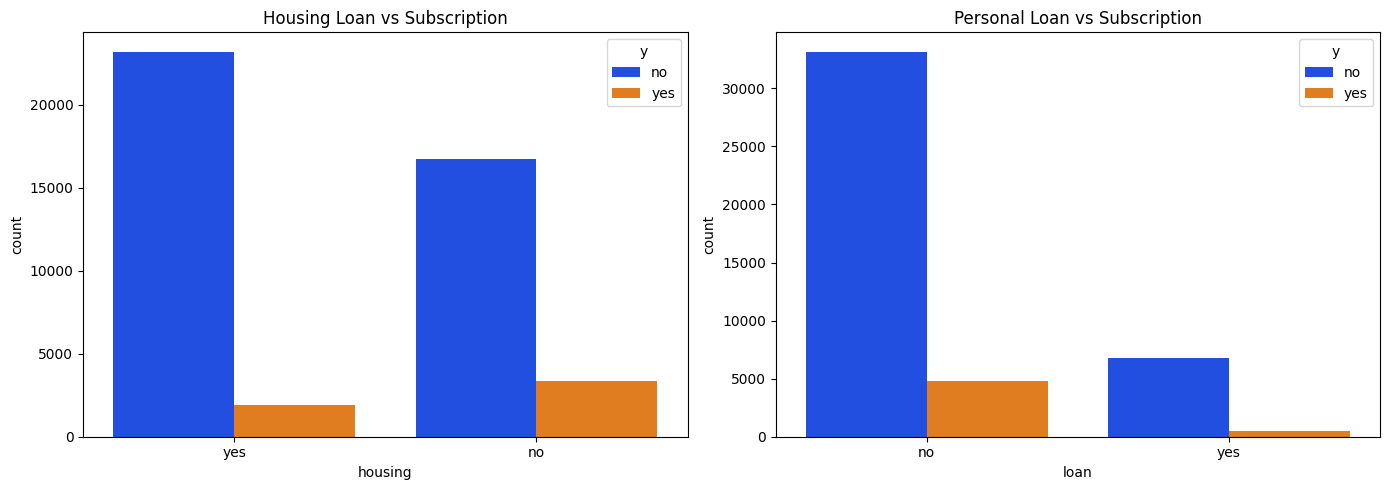

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(data=data, x='housing', hue='y', ax=axes[0], palette='bright')
axes[0].set_title('Housing Loan vs Subscription')

sns.countplot(data=data, x='loan', hue='y', ax=axes[1], palette='bright')
axes[1].set_title('Personal Loan vs Subscription')

plt.tight_layout()
plt.show()

Clients without housing loans or personal loans are more likely to subscribe to a term deposit. Financial obligations like existing loans may reduce a client's capacity or willingness to commit to long-term savings products.

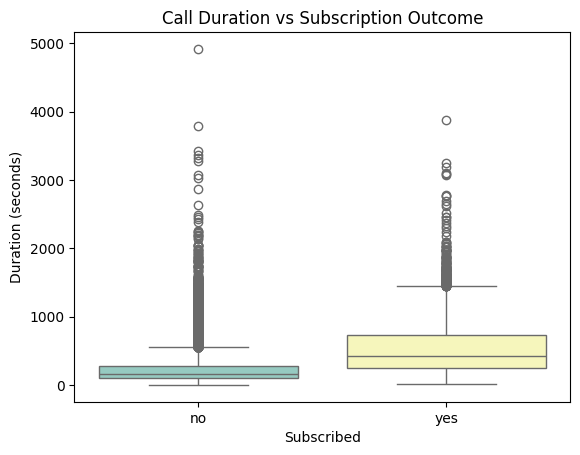

In [13]:
sns.boxplot(data=data, x='y', y='duration', hue='y', palette='Set3')
plt.title('Call Duration vs Subscription Outcome')
plt.xlabel('Subscribed')
plt.ylabel('Duration (seconds)')
plt.show()

There's a clear distinction in call duration between the two groups: clients who subscribed had significantly longer calls. This makes sense — longer conversations likely reflect stronger interest. However, this variable introduces data leakage, as it is only known after the outcome is determined. It should be excluded from predictive modeling.

### Modeling

Machine learning model that predicts whether a client will subscribe to a term deposit.

The target variable `y` is binary (yes/no), and the task is a classic classification problem.

In [14]:
df_encoded = data.copy()
df_encoded = df_encoded.drop(columns=['duration'])
df_encoded['y'] = df_encoded['y'].map({'yes': 1, 'no': 0})
df_encoded = pd.get_dummies(df_encoded, drop_first=True)
df_encoded.head()

,age,balance,day,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,1,-1,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,29,5,1,-1,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,5,1,-1,0,0,False,True,False,...,False,False,False,True,False,False,False,False,False,True
3,47,1506,5,1,-1,0,0,True,False,False,...,False,False,False,True,False,False,False,False,False,True
4,33,1,5,1,-1,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True


#### Pairplot Analysis

Pairplot shows how features relate to the target variable. This is useful for visualizing feature separation and potential linear/nonlinear patterns.

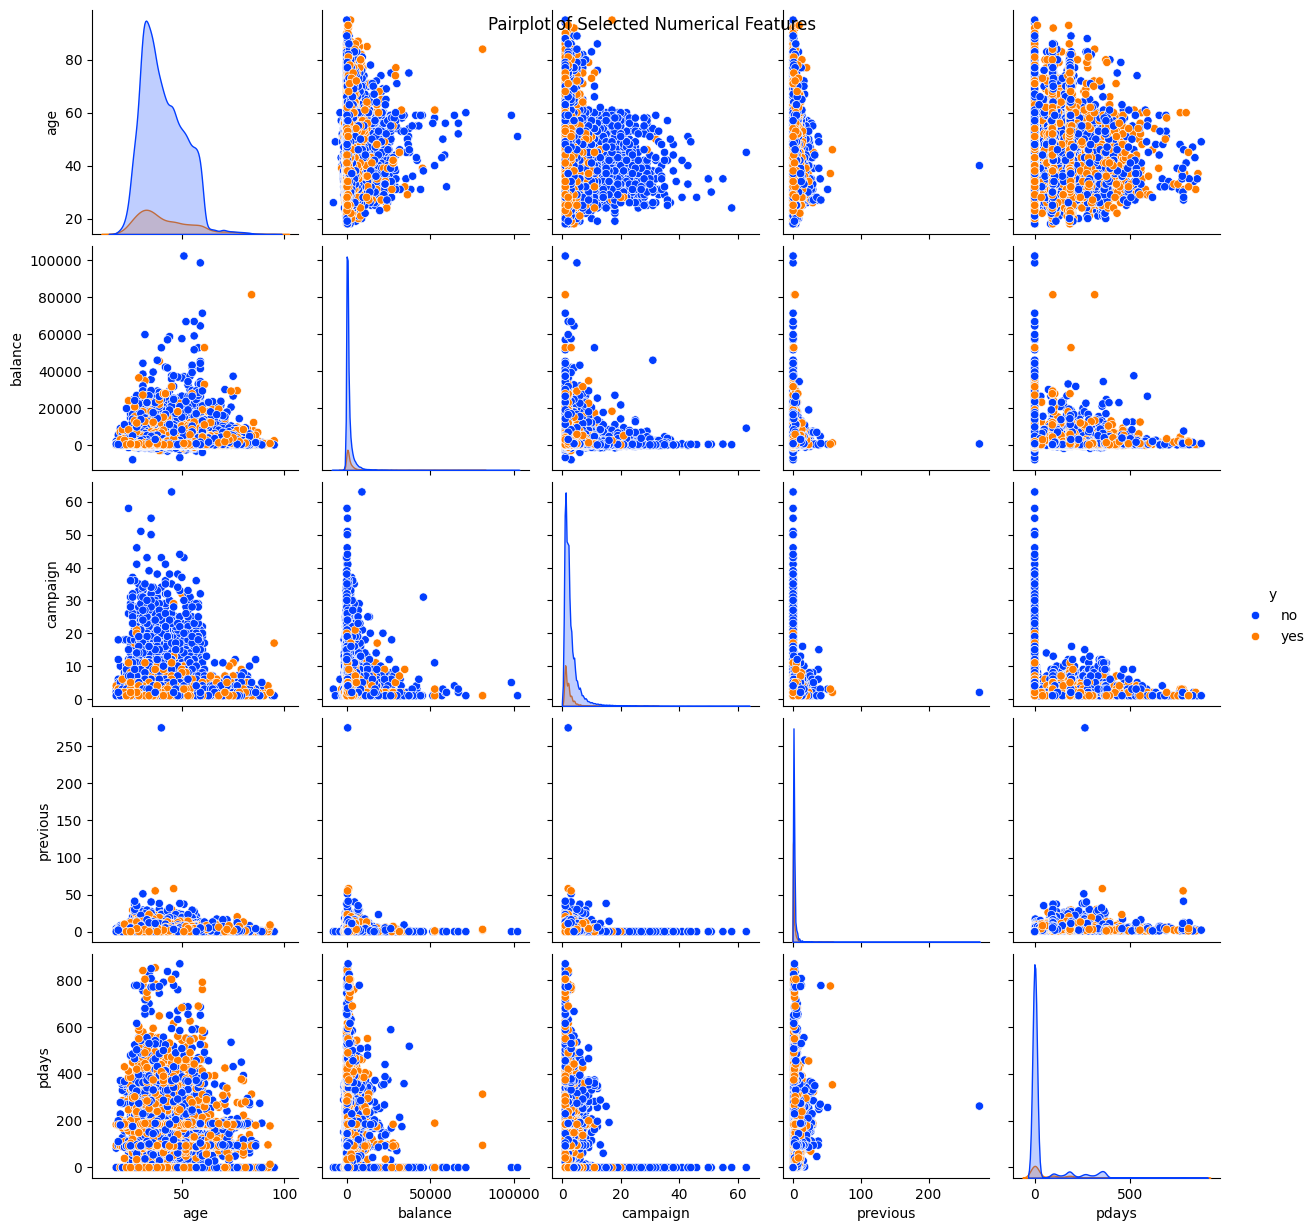

In [15]:
selected_cols = ['age', 'balance', 'campaign', 'previous', 'pdays', 'y']

sns.pairplot(df[selected_cols], hue='y', palette='bright')
plt.suptitle('Pairplot of Selected Numerical Features')
plt.show()

Observations: 

- Most numerical features such as `balance`, `pdays`, and `campaign` are highly skewed.
- Clients who subscribed (`y = yes`) tend to have slightly higher age and previous contact history.
- The dataset contains strong outliers, especially in the `balance` feature.
- These observations indicate the potential need for feature scaling or transformation.

#### Random Forest Classifier

We now train a Random Forest model to classify whether a client will subscribe to a term deposit.  
This algorithm handles non-linearities, interactions, and is robust to skewed distributions.

In [16]:
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [17]:
print("Classification report:")
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9981
           1       0.65      0.23      0.34      1322

    accuracy                           0.90     11303
   macro avg       0.78      0.61      0.64     11303
weighted avg       0.88      0.90      0.87     11303



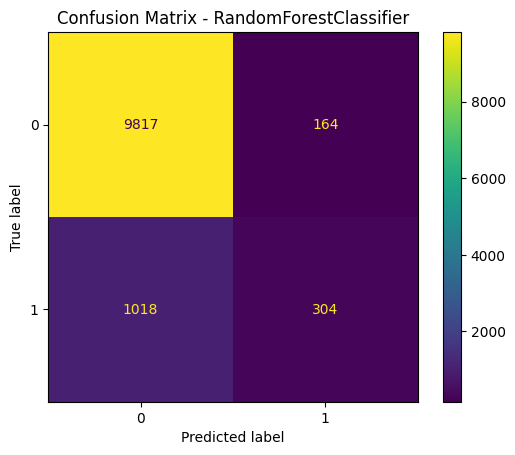

In [18]:
cm = confusion_matrix(y_test, y_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
cm_disp.plot()
plt.title("Confusion Matrix - RandomForestClassifier")
plt.show()

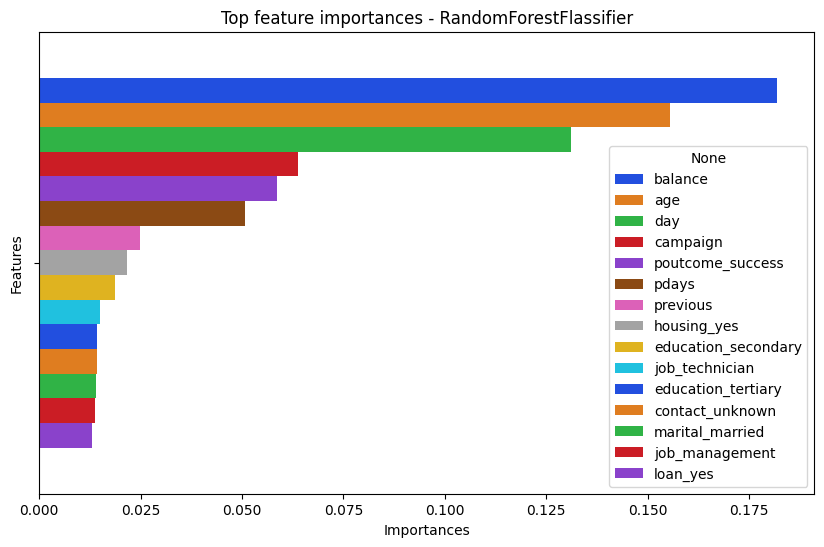

In [19]:
importances = rf_model.feature_importances_
features = X.columns
rf_importances = pd.Series(importances, index=features).sort_values(ascending=False)
n = 15

plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances[:n], hue=rf_importances.index[:n], palette='bright')
plt.title("Top feature importances - RandomForestFlassifier")
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show()

Model Performance Summary

The Random Forest classifier achieves a high overall accuracy of 90%, largely due to the class imbalance.

- It performs very well on predicting "no" (non-subscribers), with 98% recall.
- However, the recall for "yes" class is only 23%, which means the model misses most actual subscribers.
- This imbalance leads to a lower F1-score for class 1 (0.34), despite decent precision (0.65).

#### XGBoost Classifier

Evolving XGBoost model can improve prediction quality, especially for the minority class (`y = 1`).  
XGBoost often performs better in imbalanced settings, due to its handling of gradient-based boosting and regularization.

In [20]:
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [21]:
print("Classification report - XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Classification report - XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9981
           1       0.61      0.27      0.37      1322

    accuracy                           0.89     11303
   macro avg       0.76      0.62      0.66     11303
weighted avg       0.87      0.89      0.88     11303



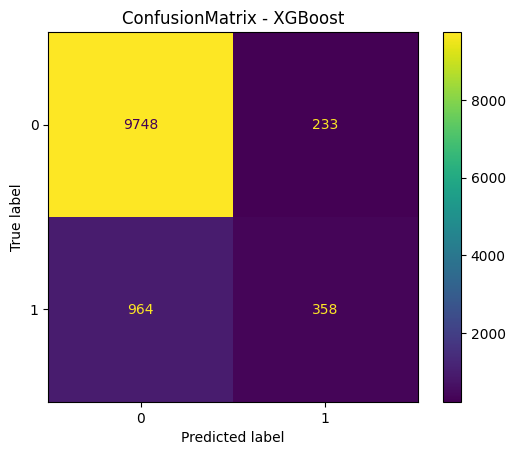

In [22]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb_disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=None)
cm_xgb_disp.plot()
plt.title("ConfusionMatrix - XGBoost")
plt.show()

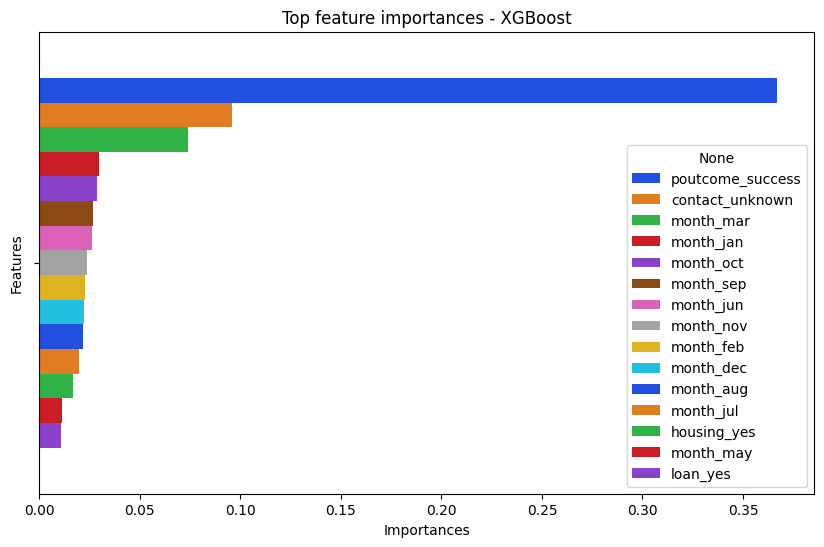

In [23]:
importances = xgb_model.feature_importances_
xgb_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=xgb_importances[:n], hue=xgb_importances.index[:n], palette='bright')
plt.title("Top feature importances - XGBoost")
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show()

XGBoost Performance Summary

- The XGBoost model slightly outperforms Random Forest in recall and F1-score for the minority class.
- Accuracy remains stable (~89–90%), but XGBoost captures more true "yes" cases.
- Feature importance reveals `poutcome_success` as the strongest single predictor.


#### SMOTE

SMOTE can be applied to the training set to improve recall on the minority class

In [24]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# print(len(y_train))
# print(len(y_train_smote))

In [25]:
xgb_smote = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42, eval_metric='logloss')
xgb_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = xgb_smote.predict(X_test)

In [26]:
print("Classification report - SMOTE")
print(classification_report(y_test, y_pred_smote))

Classification report - SMOTE
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      9981
           1       0.46      0.35      0.40      1322

    accuracy                           0.88     11303
   macro avg       0.69      0.65      0.66     11303
weighted avg       0.86      0.88      0.87     11303



ConfusionMatrix - SMOTE


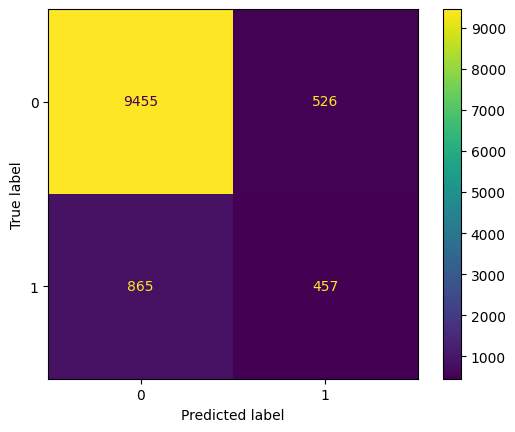

In [27]:
cm_smote = confusion_matrix(y_test, y_pred_smote)
cm_smote_disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=None)
cm_smote_disp.plot()
print("ConfusionMatrix - SMOTE")
plt.show()

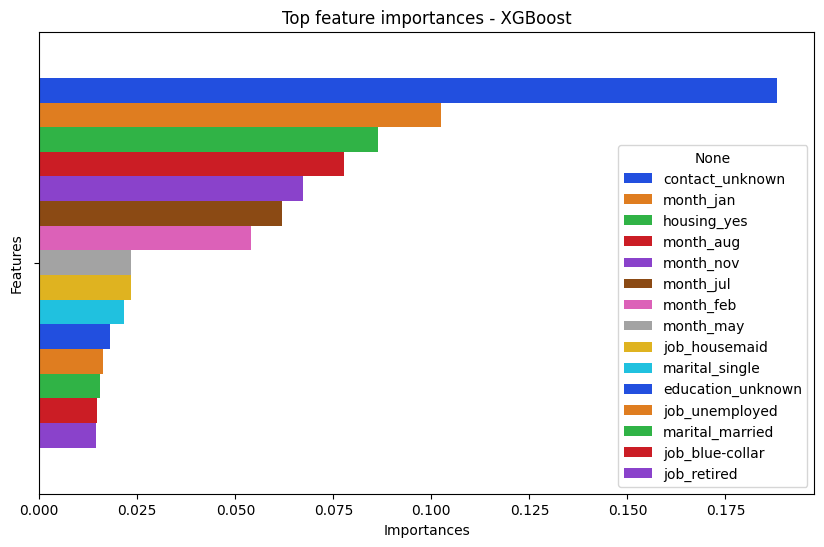

In [28]:
importances = xgb_smote.feature_importances_
xgb__smote_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=xgb__smote_importances[:n], hue=xgb__smote_importances.index[:n], palette='bright')
plt.title("Top feature importances - XGBoost")
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show()

SMOTE Performance Summary

- Recall on class 1 ("yes") improved from 0.27 -> 0.35
- F1-score increased to 0.40
- Slight drop in precision, but this is an acceptable trade-off in this case

The model is now better at identifying true potential subscribers, which would be critical for targeting in a real-world campaign.


#### GridSearchCV

GridSearchCV systematically explores combinations of hyperparameters to identify the best-performing XGBoost model — in our case, focusing specifically on maximizing recall for the minority class ("yes").

In [29]:
param_grid = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [8, 10, 12, 14, 16],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

gs_base = XGBClassifier(random_state=42, eval_metric='logloss')
gs = GridSearchCV(estimator=gs_base, param_grid=param_grid, scoring='recall', cv=3, verbose=1, n_jobs=1)
gs.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1],
                         'max_depth': [8, 10, 12, 14, 16],
                         'n_estimators': [100, 200, 300, 400],
                         'subsample': [0.8, 1.0]},
             scoring='recall', verbose=1)

In [30]:
print("Best parameters: \n", gs.best_params_)

Best parameters: 
 {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 400, 'subsample': 0.8}


In [31]:
best_gs = gs.best_estimator_

y_pred_gs_best = best_gs.predict(X_test)

In [32]:
print("Classification report - GridSearchCV")
print(classification_report(y_test, y_pred_gs_best))

Classification report - GridSearchCV
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      9981
           1       0.48      0.32      0.38      1322

    accuracy                           0.88     11303
   macro avg       0.69      0.64      0.66     11303
weighted avg       0.86      0.88      0.87     11303



ConfusionMatrix - GridSearchCV


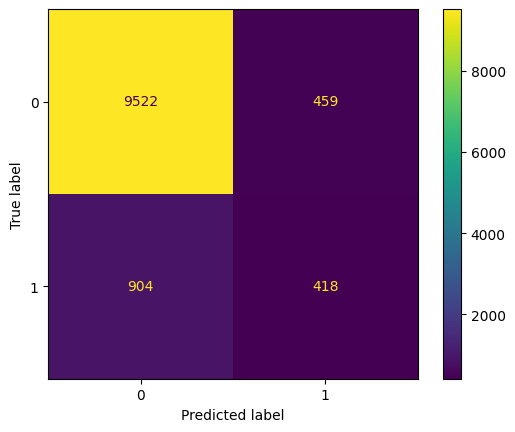

In [33]:
cm_gs = confusion_matrix(y_test, y_pred_gs_best)
cm_gs_disp = ConfusionMatrixDisplay(confusion_matrix=cm_gs, display_labels=None)
cm_gs_disp.plot()
print("ConfusionMatrix - GridSearchCV")
plt.show()

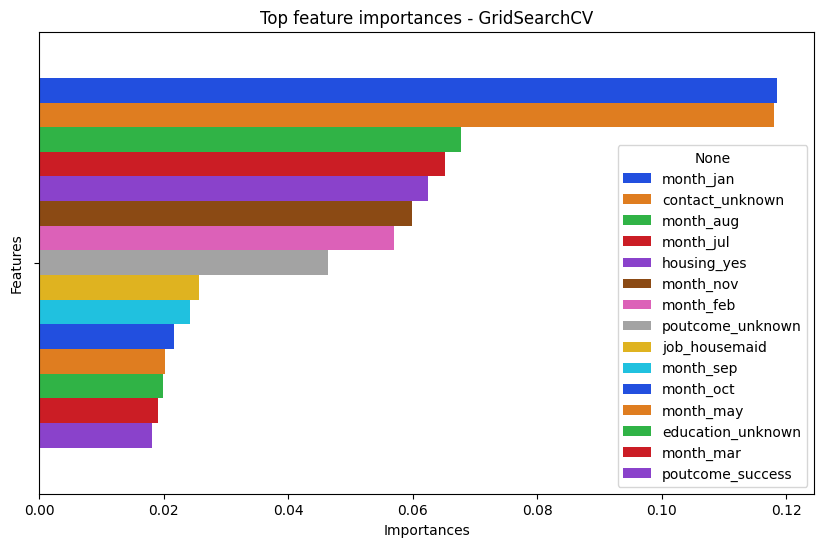

In [34]:
importances = best_gs.feature_importances_
gs_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=gs_importances[:n], hue=gs_importances.index[:n], palette='bright')
plt.title("Top feature importances - GridSearchCV")
plt.xlabel("Importances")
plt.ylabel("Features")
plt.show()

GridSearchCV Performance Summary

- The tuned XGBoost model achieved an accuracy of 88%, which is consistent with previous versions.
- Most importantly, it improved the model's ability to detect the minority class (`y = 1`):
  - Recall is equal to 0.32
  - F1-score is equal to 0.38
- While precision dropped slightly, this is a reasonable trade-off in marketing scenarios where capturing more potential subscribers is more valuable than avoiding false positives.

GridSearchCV allowed us to extract more value from the model by fine-tuning parameters like `max_depth`, `n_estimators`, and `learning_rate`, which together improved its ability to generalize from the oversampled data.


#### SHAP

To explain how our XGBoost model makes predictions, we used SHAP values:

- The summary plot highlights global feature importance and their impact.
- The waterfall plot breaks down the contribution of individual features for a specific prediction.

This allows to justify each model decision.


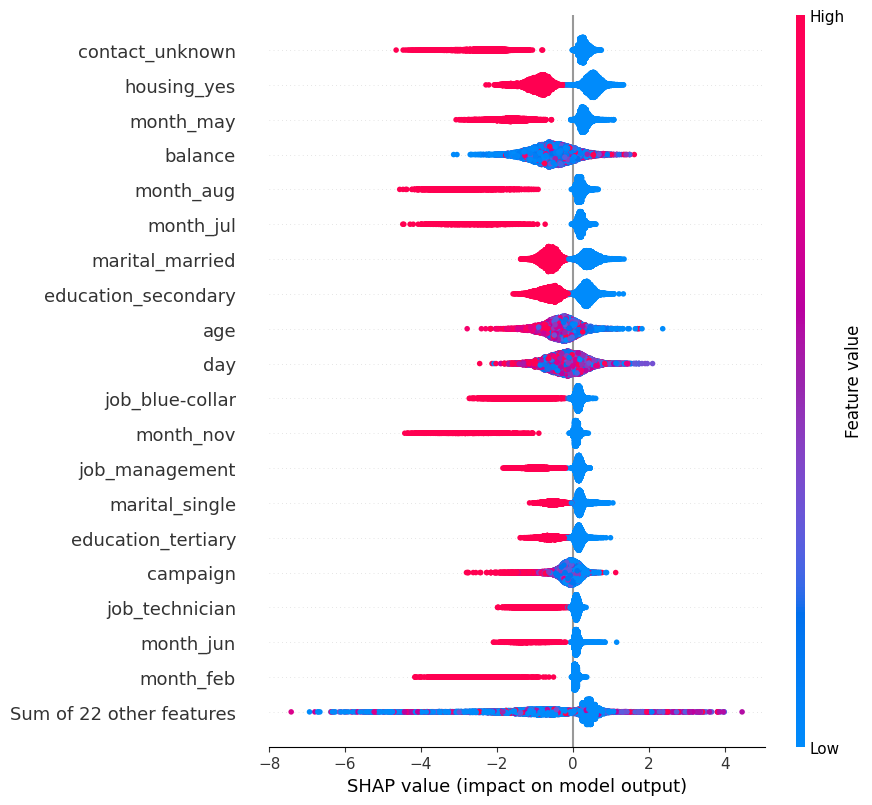

In [37]:
explainer = shap.Explainer(best_gs)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=20)

SHAP Summary Plot

The SHAP summary plot shows the top features that impact the model's predictions:

- Each dot is a prediction for one customer.
- Color = feature value (red = high, blue = low)
- Position on the x-axis = impact on the output (SHAP value)

Key insights:
- `contact_unknown` and `housing_yes` have the strongest global influence.
- Being contacted through unknown channels decreases the chance of subscription (this case requires further investigation).
- Having a housing loan (`housing_yes=True`) typically lowers the probability of subscribing.
- Marketing campaign timing (`month_`) has high influence — campaigns in May and August are impactful (positive or negative depending on direction).
- Customer balance, age, and marital status also influence predictions, but in a lesser extent.

This view helps explain what patterns the model relies on most often.

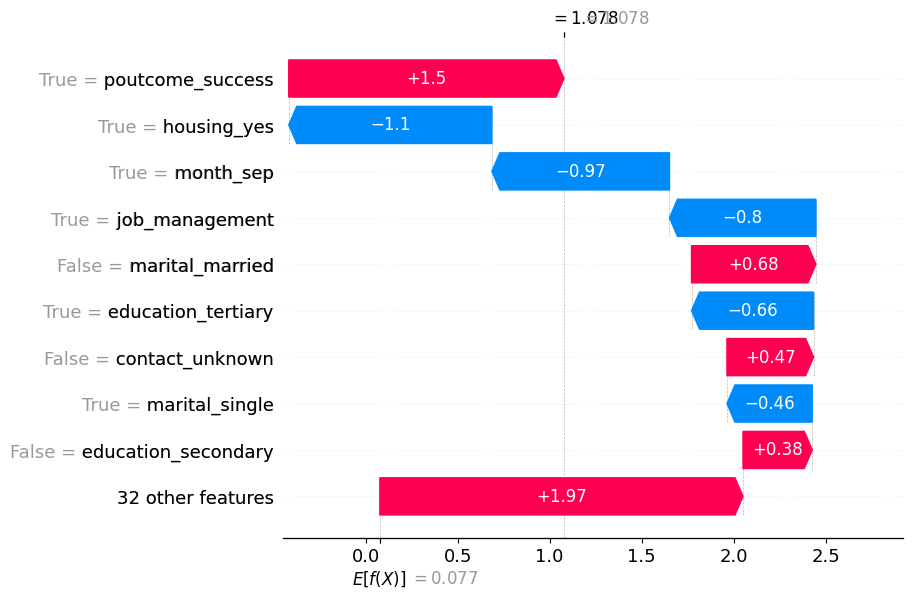

In [45]:
i=20
shap.plots.waterfall(shap_values[i])

SHAP Waterfall Plot – Individual Prediction 

This SHAP waterfall plot explains why the model made a specific prediction for one customer.

- The base value (E[f(x)]) is the model's expected output (average prediction).
- Features either push the prediction up (toward "yes") or lower it (toward "no").

Example explanation (for i=20):

Positive indicators:
- `poutcome_success = True` - +1.50 - The client had a successful outcome in a previous campaign, which strongly increases the chances to subscribe again.
- Not being married (`marital_married = False`) - +0.68 - Unmarried clients can be more flexible/responsive.
- `contact_unknown = False` - +0.47 - Having a known contact method contributes positively.
- `marital_single = True` - +0.47 - Strengthens the positive impact of not being married.
- `education_secondary = False` - +0.38 - Not having just secondary education slightly increases likelihood.

Negative indicators:
- `housing_yes = True` - -1.10 - Having a housing loan lowers the chance of subscription.
- `month_sep = True` - -0.97 - Campaigns in September are less effective for this client (for example more expenses during this time).
- `job_management = True` - -0.80 - Clients in management roles are less likely to subscribe.
- `education_tertiary = True` - -0.66 - Higher education doesn't guarantee higher interest here.

Overall, the positive effects outweight the negatives, so this client is more likely to subscribe (`y = 1`).


This allows us to justify and understand the prediction, which is critical for business decisions or building trust in AI systems.


#### ROC Curve & AUC

The ROC curve gives a visual representation of the trade-offs between the true positive rate (TPR) and false positive rate (FPR) at various thresholds.
The AUC score quantifies this ability. A perfect classifier would score 1.0, while random guessing results in 0.5.
The tuned XGBoost model achieved an AUC of ~0.84–0.87.

ROC is threshold-independent, making it a robust evaluation metric for imbalanced datasets like this one.


In [53]:
y_probs = best_gs.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {roc_auc:.4f}")

AUC Score: 0.7666


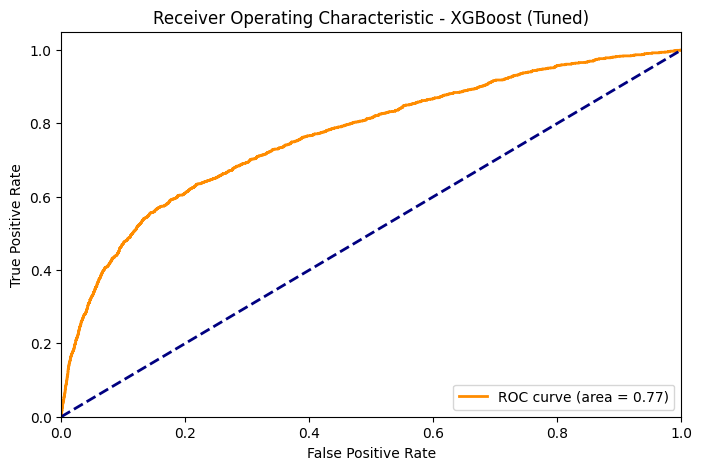

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost (Tuned)')
plt.legend(loc="lower right")
plt.show()

ROC Curve & AUC Summary – Tuned XGBoost

The ROC curve visualizes the model’s performance across all classification thresholds.

- The orange curve represents the trade-off between the True Positive Rate and False Positive Rate.
- The dashed diagonal line represents a no-skill classifier (random guessing).
- Our model's curve stays well above this baseline.

AUC = 0.77
This means the model has a 77% chance of correctly ranking a positive instance higher than a negative one - it's a strong result for an imbalanced classification task.

This validates that the tuned XGBoost model (after applying SMOTE and GridSearch) generalizes well and can distinguish subscribers from non-subscribers reliably.


#### Model Export – Pickle

The final tuned XGBoost model was saved using the `pickle` module.

In [55]:
with open('xgb_tuned_model.pkl', 'wb') as f:
    pickle.dump(best_gs, f)

In [56]:
# with open('xgb_tuned_model.pkl', 'rb') as f:
#    model_loaded = pickle.load(f)

# Project Summary

The goal of this project was to predict whether a client will subscribe to a term deposit product based on historical bank marketing data.

This classification problem is highly imbalanced and simulates a real-world direct marketing challenge.

- There was no missing values
- Visualization analysis was performed in Python (Seaborn, Matplotlib) and then in Tableau
- Categorical variables were transformed through One-Hot Encoding
- SMOTE oversampling was applied to address class imbalance
- XGBoost got tuned with GridSearchCV
- Confusion matrix, precision, recall, F1-score were used for evaluation
- Identified key drivers: contact type, month, balance, and campaign outcome
- 88% accuracy, F1-score ~0.38, AUC = 0.77
- Final model was exported using `pickle` (`xgb_tuned_model.pkl`)


Key Takeaways

- Campaign timing, contact channel, and previous success are the most influential factors.
- SHAP enhanced model transparency and made individual predictions explainable.